In [19]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

print("IMPORTS IMPORTED")

IMPORTS IMPORTED


In [20]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('C:\\Users\\jamie\\Untitled Folder 1\\Human_Activity_Dataset\\Seizure\\Datasets\\Datasets\\ds\\ds\\mergedfiles.txt', header = None, names = columns)
df = df.dropna()
print(columns)

['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']


In [21]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,5,Seizure,1.471980e+13,1.583,3.540,8.091;
1,5,Seizure,1.471984e+13,1.457,3.147,6.987;
2,5,Seizure,1.471988e+13,1.251,2.826,6.549;
3,5,Seizure,1.471992e+13,1.176,2.517,5.43;
4,5,Seizure,1.471996e+13,0.974,2.360,5.204;


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1147101 entries, 0 to 1147101
Data columns (total 6 columns):
user         1147101 non-null object
activity     1147101 non-null object
timestamp    1147101 non-null float64
x-axis       1147101 non-null float64
y-axis       1147101 non-null float64
z-axis       1147101 non-null object
dtypes: float64(3), object(3)
memory usage: 61.3+ MB


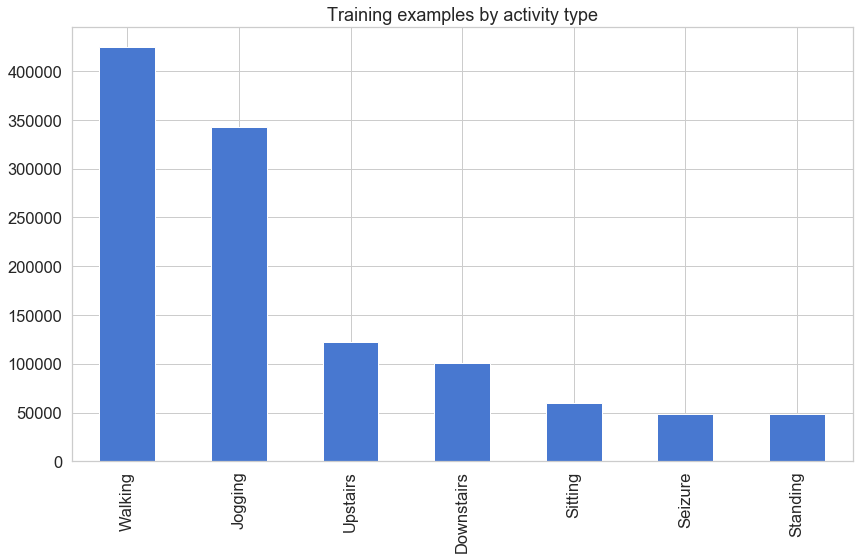

In [23]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

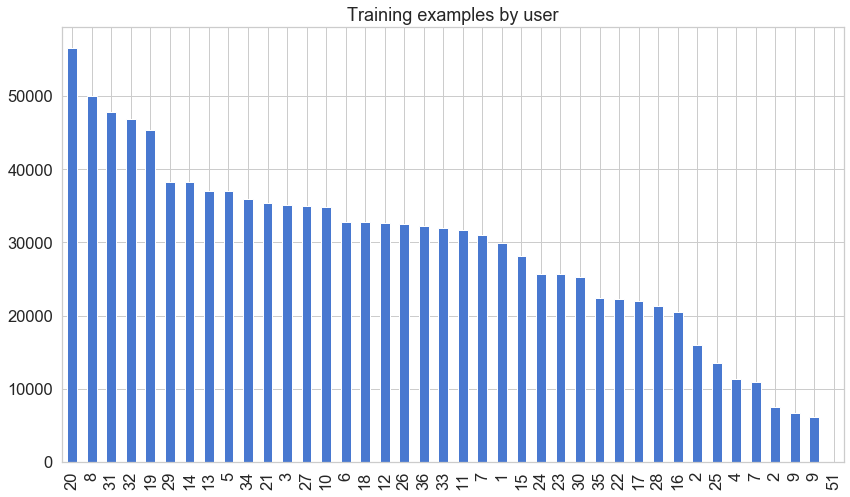

In [24]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user');

In [25]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:500]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
        
        
# Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


df.head()


,user,activity,timestamp,x-axis,y-axis,z-axis
0,5,Seizure,1.471980e+13,1.583,3.540,8.091;
1,5,Seizure,1.471984e+13,1.457,3.147,6.987;
2,5,Seizure,1.471988e+13,1.251,2.826,6.549;
3,5,Seizure,1.471992e+13,1.176,2.517,5.43;
4,5,Seizure,1.471996e+13,0.974,2.360,5.204;


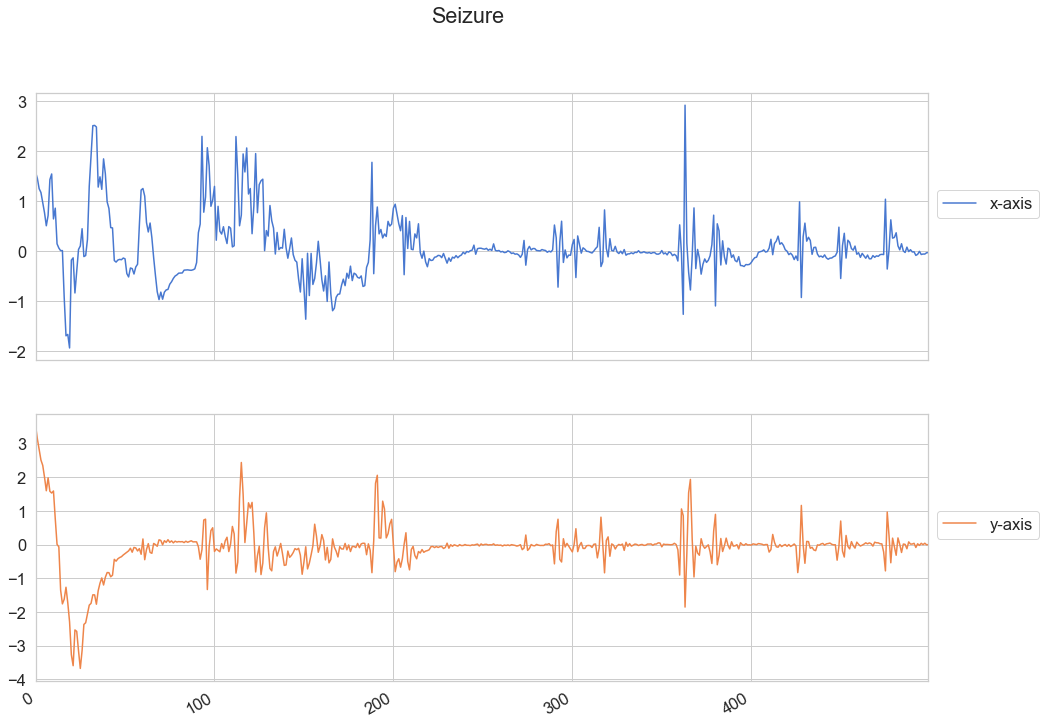

In [26]:
plot_activity("Seizure", df)


Data preprocessing
Our LSTM (covered in the previous part of the series) model expects fixed-length sequences as training data. We'll use a familiar method for generating these. Each generated sequence contains 200 training examples:

In [27]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [28]:
np.array(segments).shape



(57346, 3, 200)

In [29]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [30]:
reshaped_segments.shape


(57346, 200, 3)

In [31]:
labels[0]


array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [33]:
len(X_train)

45876

In [34]:
len(X_test)


11470

# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:



In [35]:
N_CLASSES = 7
N_HIDDEN_UNITS = 64
print("YAY")

YAY


In [36]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [37]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [38]:

pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

W0610 03:50:33.583237 15076 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0610 03:50:33.584237 15076 deprecation.py:323] From <ipython-input-36-c8ae7df74e6e>:17: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0610 03:50:33.585232 15076 deprecation.py:323] From <ipython-input-36-c8ae7df74e6e>:18: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is

In [39]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

W0610 03:50:38.709829 15076 deprecation.py:323] From <ipython-input-39-4720b2143aa0>:6: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [20]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

In [41]:
N_EPOCHS = 50
BATCH_SIZE = 1024
print("YAY")

YAY


In [22]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_trai
                                 n)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} f loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} Final loss: {loss_final}')

epoch: 1 test accuracy: 0.7941305637359619 f loss: 1.3398373126983643
epoch: 10 test accuracy: 0.9216237664222717 f loss: 0.6612619161605835
epoch: 20 test accuracy: 0.9480713605880737 f loss: 0.45836901664733887
epoch: 30 test accuracy: 0.9639750719070435 f loss: 0.34235450625419617
epoch: 40 test accuracy: 0.9691591262817383 f loss: 0.28941458463668823
epoch: 50 test accuracy: 0.961075484752655 f loss: 0.29221057891845703

final results: accuracy: 0.961075484752655 Final loss: 0.29221057891845703


In [27]:
tf.InteractiveSession._active_session_count

3

In [28]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

NotFoundError: Failed to create a NewWriteableFile: .\./checkpoint/har.pbtxt.tmpe71973a2538640d9adf4622642d271f6 : The system cannot find the path specified.
; No such process

In [ ]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

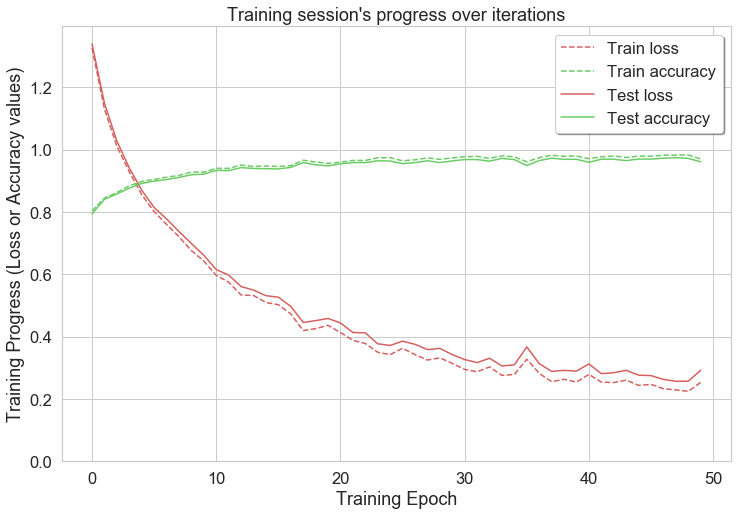

In [23]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [24]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
print(LABELS)


['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


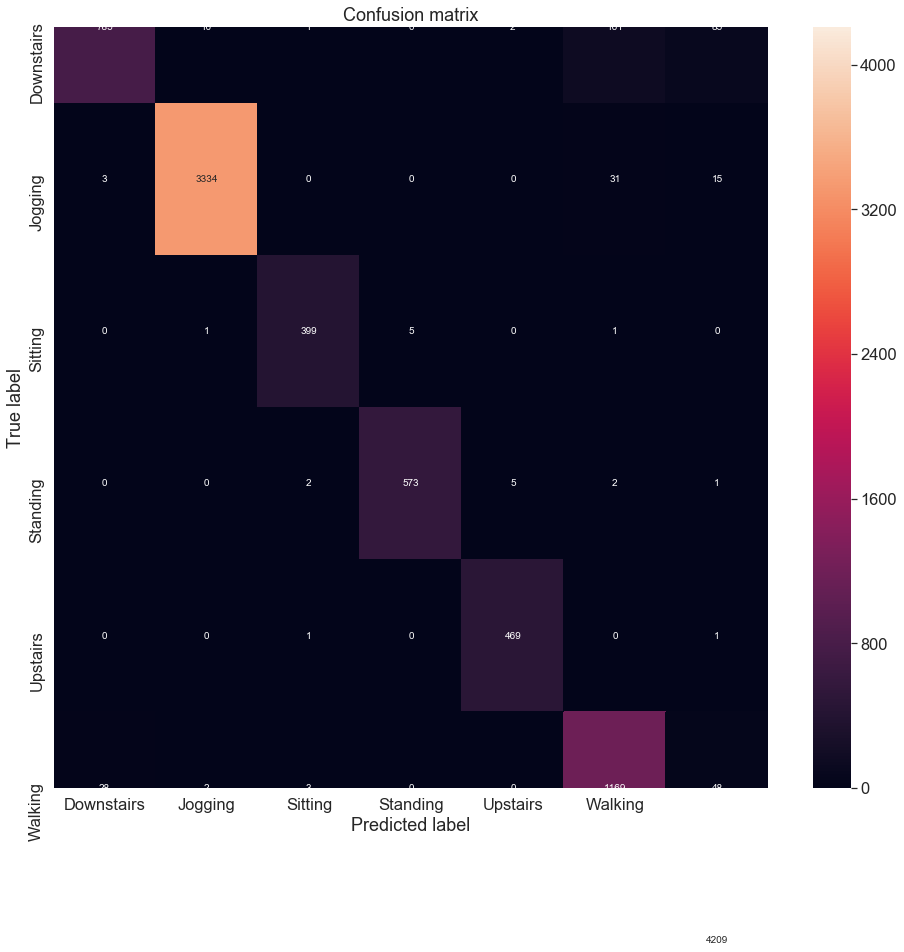

In [25]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();